# PyTorch: Logistic Regression with MNIST

In [1]:
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
import numpy as np

In [3]:
np.random.seed(0)

In [4]:
dataset = MNIST('dataset/', download=True)

In [5]:
len(dataset)

60000

In [6]:
test_dataset = MNIST('dataset/', train=False)
len(test_dataset)

10000

In [7]:
 dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x1709F992C88>, 5)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

Text(0.5, 1.0, '5')

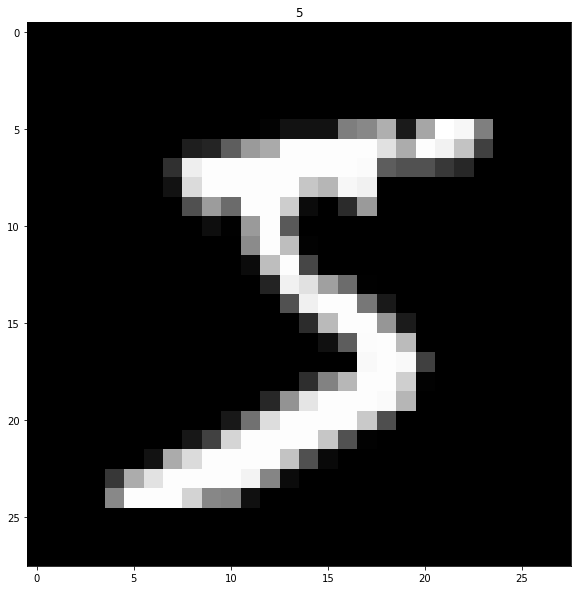

In [9]:
image, label = dataset[0]
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.title(label)

Text(0.5, 1.0, '3')

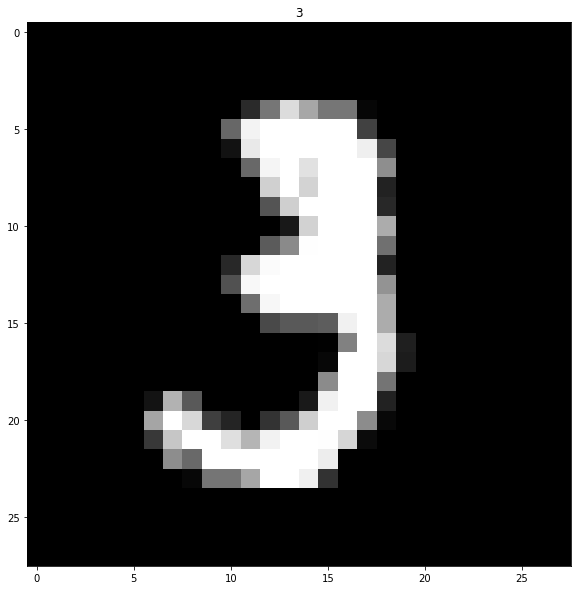

In [10]:
image, label = dataset[10]
plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')
plt.title(label)

In [11]:
import torchvision.transforms as transforms

In [12]:
dataset = MNIST('dataset/', train=True, transform=transforms.ToTensor())

In [13]:
img_tensor, label = dataset[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [14]:
print(img_tensor[:, 10:15, 10:15])

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])


In [15]:
torch.max(img_tensor), torch.min(img_tensor)

(tensor(1.), tensor(0.))

Text(0.5, 1.0, '5')

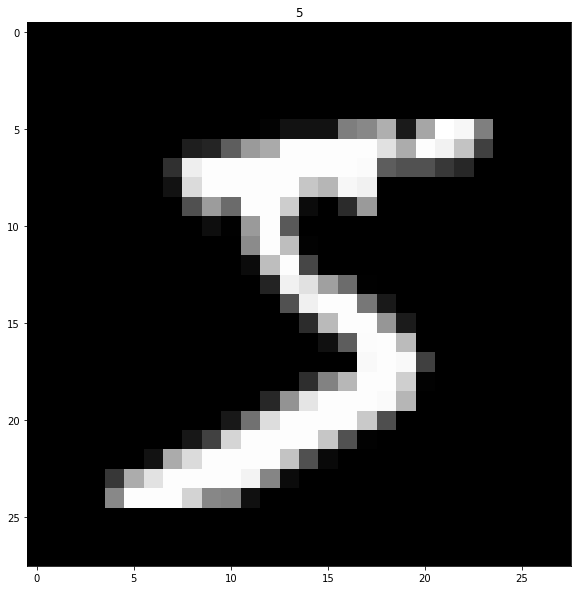

In [16]:
image, label = dataset[0]
plt.figure(figsize=(10, 10))
plt.imshow(image[0], cmap='gray')
plt.title(label)

In [17]:
def split_indices(n, val_pct):
    n_val = int(val_pct * n)
    idxs = np.random.permutation(n)
    return idxs[n_val:], idxs[:n_val]

In [18]:
train_idxs, val_idxs = split_indices(len(dataset), 0.2)

In [19]:
print(len(train_idxs), len(val_idxs))
print('Sample validation indices:', val_idxs[:10])

48000 12000
Sample validation indices: [ 3048 19563 58303  8870 40228 31488 21860 56864   845 25770]


In [20]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [21]:
batch_size = 64
train_sampler = SubsetRandomSampler(train_idxs)
train_loader = DataLoader(dataset, batch_size, sampler=train_sampler)
val_sampler = SubsetRandomSampler(val_idxs)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)

In [22]:
import torch.nn as nn

In [23]:
import torch.nn.functional as F

In [24]:
input_size = 28 * 28
num_classes = 10

In [25]:
learning_rate = 1e-3

In [26]:
class MnistModel (nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, input_size)
        out = self.linear(xb)
        return out

In [27]:
def loss_batch(model, loss_func, xb, yb, opt=None, metric=None):
    preds = model(xb)
    loss = loss_func(preds, yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    
    metric_result = None
    if metric is not None:
        metric_result = metric(preds, yb)
    
    return loss.item(), len(xb), metric_result

In [28]:
def evaluate(model, loss_fn, valid_dl, metric=None):
    with torch.no_grad():
        results = [loss_batch(model, loss_fn, xb, yb, metric=metric) for xb, yb in valid_dl]
        losses, nums, metrics = zip(*results)
        
        total = np.sum(nums)
        avg_loss = np.sum(np.multiply(losses, nums)) / total
        
        avg_metric = None
        if metric is not None:
            avg_metric = np.sum(np.multiply(metrics, nums)) / total

    return avg_loss, total, avg_metric

In [29]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.sum(preds == labels).item() / len(preds)

In [30]:
def fit(epochs, model, loss_fn, opt, train_dl, valid_dl, metric=None):
    for epoch in range(epochs):
        for xb, yb in train_dl:
            loss, _, _ = loss_batch(model, loss_fn, xb, yb, opt)
        
        result = evaluate(model, loss_fn, valid_dl, metric)
        val_loss, total, val_metric = result

        if metric is None:
            print('Epoch [{}/{}], Loss: {:.5f}'.format(epoch + 1, epochs, val_loss))
        else:
            print('Epoch [{}/{}], Loss: {:.5f}, {}: {:.5f}'.format(epoch + 1, epochs, val_loss, metric.__name__, val_metric))

In [31]:
model = MnistModel()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [32]:
fit(20, model, F.cross_entropy, optimizer, train_loader, val_loader, accuracy)

Epoch [1/20], Loss: 1.72981, accuracy: 0.69367
Epoch [2/20], Loss: 1.36769, accuracy: 0.77467
Epoch [3/20], Loss: 1.15026, accuracy: 0.80442
Epoch [4/20], Loss: 1.00977, accuracy: 0.81800
Epoch [5/20], Loss: 0.91237, accuracy: 0.82933
Epoch [6/20], Loss: 0.84099, accuracy: 0.83600
Epoch [7/20], Loss: 0.78637, accuracy: 0.84150
Epoch [8/20], Loss: 0.74316, accuracy: 0.84500
Epoch [9/20], Loss: 0.70795, accuracy: 0.84975
Epoch [10/20], Loss: 0.67871, accuracy: 0.85242
Epoch [11/20], Loss: 0.65396, accuracy: 0.85542
Epoch [12/20], Loss: 0.63268, accuracy: 0.85742
Epoch [13/20], Loss: 0.61420, accuracy: 0.85958
Epoch [14/20], Loss: 0.59793, accuracy: 0.86192
Epoch [15/20], Loss: 0.58348, accuracy: 0.86408
Epoch [16/20], Loss: 0.57055, accuracy: 0.86558
Epoch [17/20], Loss: 0.55891, accuracy: 0.86583
Epoch [18/20], Loss: 0.54834, accuracy: 0.86767
Epoch [19/20], Loss: 0.53870, accuracy: 0.86983
Epoch [20/20], Loss: 0.52988, accuracy: 0.87075


[Text(0, 0.5, 'Accuracy (in %)'),
 Text(0.5, 0, 'Number of epoch'),
 Text(0.5, 1.0, 'Accuracy vs Number of epochs')]

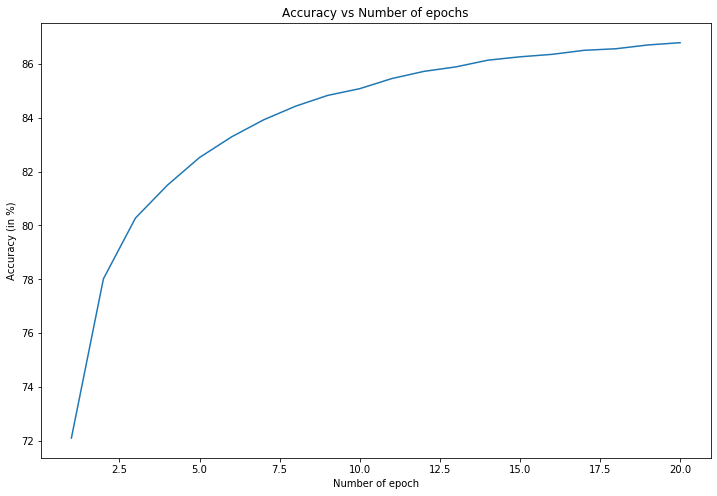

In [33]:
accuracies = [0.72100, 0.78017, 0.80275, 0.81500, 0.82525,
              0.83292, 0.83925, 0.84433, 0.84833, 0.85083,
              0.85458, 0.85725, 0.85892, 0.86142, 0.86267,
              0.86358, 0.86508, 0.86567, 0.86708, 0.86792]
plt.figure(figsize=(12, 8))
sns.lineplot(x=range(1, 21), y=[x * 100 for x in accuracies]).set(title='Accuracy vs Number of epochs', xlabel='Number of epoch', ylabel='Accuracy (in %)')

In [34]:
test_dataset = MNIST(root='dataset/', train=False, transform=transforms.ToTensor())

In [35]:
img, label = test_dataset[0]
print(img.shape, img.unsqueeze(0).shape)

torch.Size([1, 28, 28]) torch.Size([1, 1, 28, 28])


In [36]:
def predict_img(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Text(0.5, 1.0, 'Label: 7 Predicted: 7')

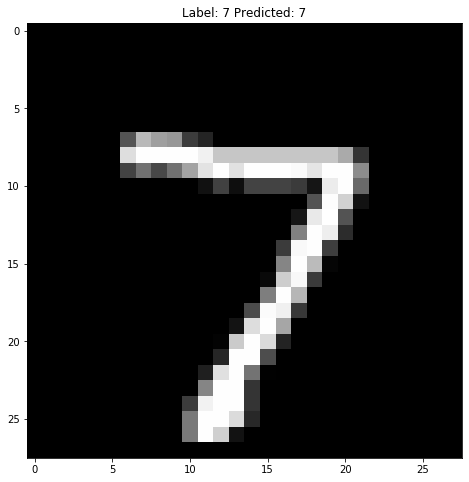

In [37]:
image, label = test_dataset[0]
plt.figure(figsize=(8, 8))
plt.imshow(image[0], cmap='gray')
plt.title('Label: ' + str(label) + ' Predicted: ' + str(predict_img(image, model)))

Text(0.5, 1.0, 'Label: 0 Predicted: 0')

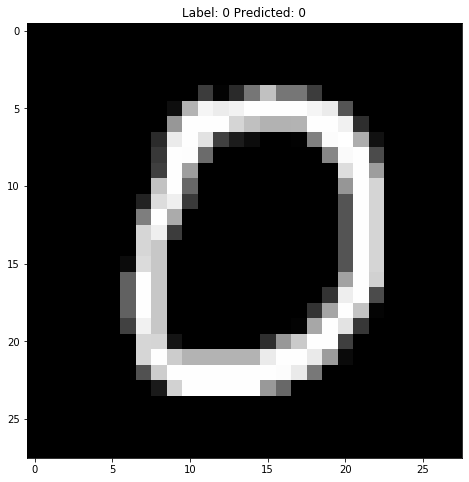

In [38]:
image, label = test_dataset[10]
plt.figure(figsize=(8, 8))
plt.imshow(image[0], cmap='gray')
plt.title('Label: ' + str(label) + ' Predicted: ' + str(predict_img(image, model)))

Text(0.5, 1.0, 'Label: 9 Predicted: 9')

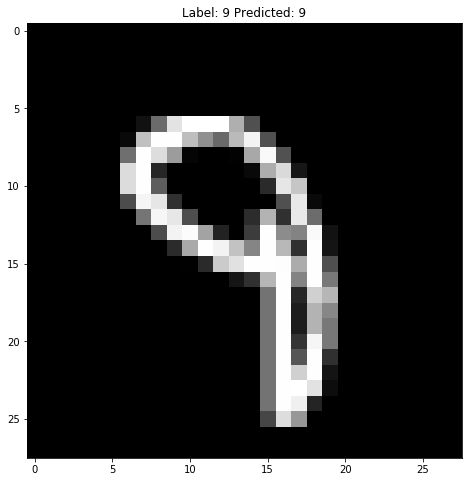

In [39]:
image, label = test_dataset[193]
plt.figure(figsize=(8, 8))
plt.imshow(image[0], cmap='gray')
plt.title('Label: ' + str(label) + ' Predicted: ' + str(predict_img(image, model)))

Text(0.5, 1.0, 'Label: 2 Predicted: 8')

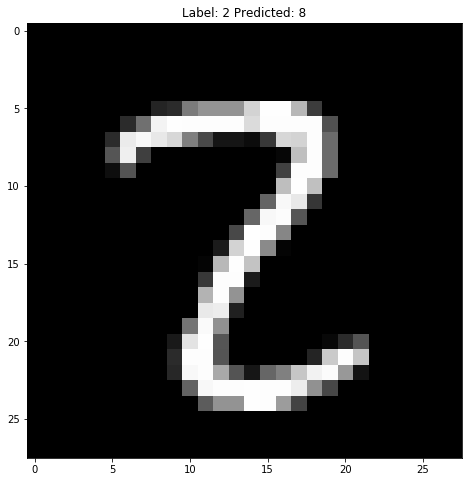

In [40]:
image, label = test_dataset[1839]
plt.figure(figsize=(8, 8))
plt.imshow(image[0], cmap='gray')
plt.title('Label: ' + str(label) + ' Predicted: ' + str(predict_img(image, model)))

Text(0.5, 1.0, 'Label: 7 Predicted: 7')

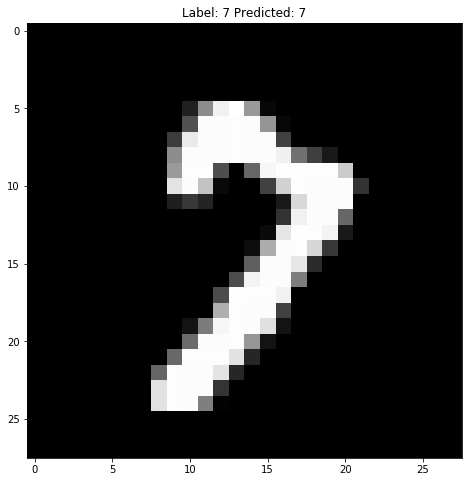

In [41]:
image, label = test_dataset[6954]
plt.figure(figsize=(8, 8))
plt.imshow(image[0], cmap='gray')
plt.title('Label: ' + str(label) + ' Predicted: ' + str(predict_img(image, model)))

In [42]:
test_loader = DataLoader(test_dataset, batch_size=batch_size)
test_loss, total, test_acc = evaluate(model, F.cross_entropy, test_loader, metric=accuracy)
print('Loss: {:.5f}, Accuray: {:.5f}'.format(test_loss, test_acc))

Loss: 0.51219, Accuray: 0.87910


In [43]:
torch.save(model.state_dict(), 'models/mnist-logistic.pth')

In [44]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0166, -0.0114,  0.0331,  ..., -0.0335,  0.0161,  0.0257],
                      [ 0.0068, -0.0153,  0.0042,  ..., -0.0291,  0.0117,  0.0338],
                      [ 0.0099,  0.0110, -0.0232,  ...,  0.0094,  0.0069, -0.0006],
                      ...,
                      [ 0.0117, -0.0091,  0.0105,  ...,  0.0216, -0.0010,  0.0204],
                      [ 0.0019, -0.0047, -0.0280,  ...,  0.0243,  0.0212, -0.0081],
                      [ 0.0070, -0.0143,  0.0350,  ..., -0.0101, -0.0253,  0.0154]])),
             ('linear.bias',
              tensor([-0.0806,  0.1562, -0.0199, -0.0490,  0.0284,  0.0805, -0.0049,  0.0426,
                      -0.1550, -0.0039]))])